In [7]:
%matplotlib inline
from IPython.display import display, Markdown
from datetime import time, datetime, date, timedelta
import snakemd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import fitfile
from garmindb import GarminConnectConfigManager
from garmindb.garmindb import GarminDb, Attributes, ActivitiesDb, Activities, StepsActivities, ActivityLaps, ActivityRecords
from idbutils.list_and_dict import list_not_none

from jupyter_funcs import format_number

gc_config = GarminConnectConfigManager()
db_params_dict = gc_config.get_db_params()

garmin_db = GarminDb(db_params_dict)
garmin_act_db = ActivitiesDb(db_params_dict)
measurement_system = Attributes.measurements_type(garmin_db)
unit_strings = fitfile.units.unit_strings[measurement_system]
distance_units = {"kilometers": "km"}[unit_strings[fitfile.units.UnitTypes.distance_long]]

def __format_activity(activity):
    if activity:
        if activity.is_steps_activity():
            steps_activity = StepsActivities.get(garmin_act_db, activity.activity_id)
#             return [activity.activity_id, activity.name, activity.start_time.strftime("%y%m%d"), activity.sport, format_number(activity.distance, 1), activity.elapsed_time, format_number(activity.avg_speed, 1), steps_activity.avg_pace, format_number(activity.calories)]
            return [activity.activity_id, activity.name, activity.start_time.strftime("%y%m%d"), activity.sport, format_number(activity.distance, 1), activity.elapsed_time, activity.moving_time, format_number(activity.avg_speed, 1), format_number(activity.calories)]
        return [activity.activity_id, activity.name, activity.start_time.strftime("%y%m%d"), activity.sport, format_number(activity.distance, 1), activity.elapsed_time, activity.moving_time, format_number(activity.avg_speed, 1), format_number(activity.calories)]
    return ['', '', '', '', '', '', '', '', '']


activities = Activities.get_latest(garmin_act_db, Activities.row_count(garmin_act_db))

In [47]:
def debug(name=None):
    doc = snakemd.new_doc()
    if (name is None):
        rows = [__format_activity(activity) for activity in activities]
    else:
        rows = [__format_activity(activity) for activity in activities if ((activity.name is not None) and (name in activity.name.lower()))]
    doc.add_heading("All Recorded Activities", 3)
    doc.add_table(['Id', 'Name', 'Date', 'Sport', f'Dist ({distance_units})', 'Elapsed Time', f'Moving Time', f'Speed ({unit_strings[fitfile.units.UnitTypes.speed]})', 'Calories'], rows)
    display(Markdown(str(doc)))

#debug()

In [102]:
import numpy as np

def __plot_activity(name:str, ydata:str, cdata:str, ylimdata = None, yticksdata:tuple[float, float] = None):
    start_dates = []
    moving_times = []
    moving_times_min = []
    distances = []
    calories = []
    time100m = []
    time1000m = []
    speed = []
    for activity in activities:
        if ((activity.name is not None) and (name in activity.name.lower())):
            s = activity.distance
            t = (datetime.combine(date.min, activity.moving_time) - datetime.min).total_seconds()
            if (s > 0):
                time100m += [t/s/10]
                time1000m += [t/s]
            else:
                time100m += [0]
                time1000m += [0]
            start_dates += [activity.start_time]
            moving_times += [t]
            moving_times_min += [t/60]
            calories += [activity.calories]
            distances += [s]
            speed += [activity.avg_speed]

    yarray = []
    carray = []
    match ydata:
        case "moving_time": yarray = moving_times
        case "moving_time_min": yarray = moving_times_min
        case "calorie": yarray = calories
        case "distance": yarray = distances
        case "time100m": yarray = time100m
        case "time1000m": yarray = time1000m
        case "speed": yarray = speed
    match cdata:
        case "moving_time": carray = moving_times
        case "moving_time_min": carray = moving_times_min
        case "calorie": carray = calories
        case "distance": carray = distances
        case "time100m": carray = time100m
        case "time1000m": carray = time1000m
        case "speed": carray = speed

    #debug(name)
    #display(Markdown(str(start_dates)))
    #display(Markdown(str(yarray)))

    fig = plt.figure(figsize=(20,5), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(start_dates, yarray, c=carray, norm=matplotlib.colors.LogNorm(), cmap="rainbow")

    x_num = dates.date2num(start_dates)
    trend = np.polyfit(x_num, yarray, 3)
    fit = np.poly1d(trend)
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.plot(dates.num2date(x_fit), fit(x_fit), "r--")

    ax = plt.gca()
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    years = plt.matplotlib.dates.YearLocator()
    months = plt.matplotlib.dates.MonthLocator()
    # yearsFmt = plt.matplotlib.dates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(months)
    # ax.xaxis.set_major_formatter(yearsFmt)

    plt.title(f"{ydata} across {len(start_dates)} {name} sessions")
    plt.colorbar(label=cdata)
    plt.ylabel(ydata)
    if ylimdata is not None:
        plt.ylim(ylimdata)
    if yticksdata is not None:
        plt.yticks(yticksdata)
    plt.show()


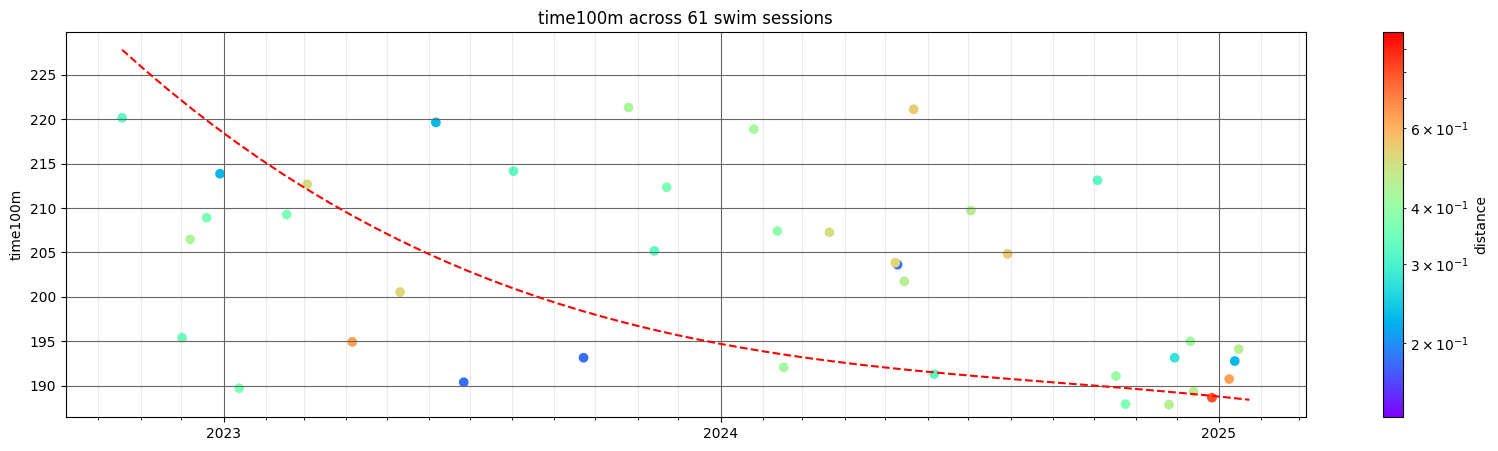

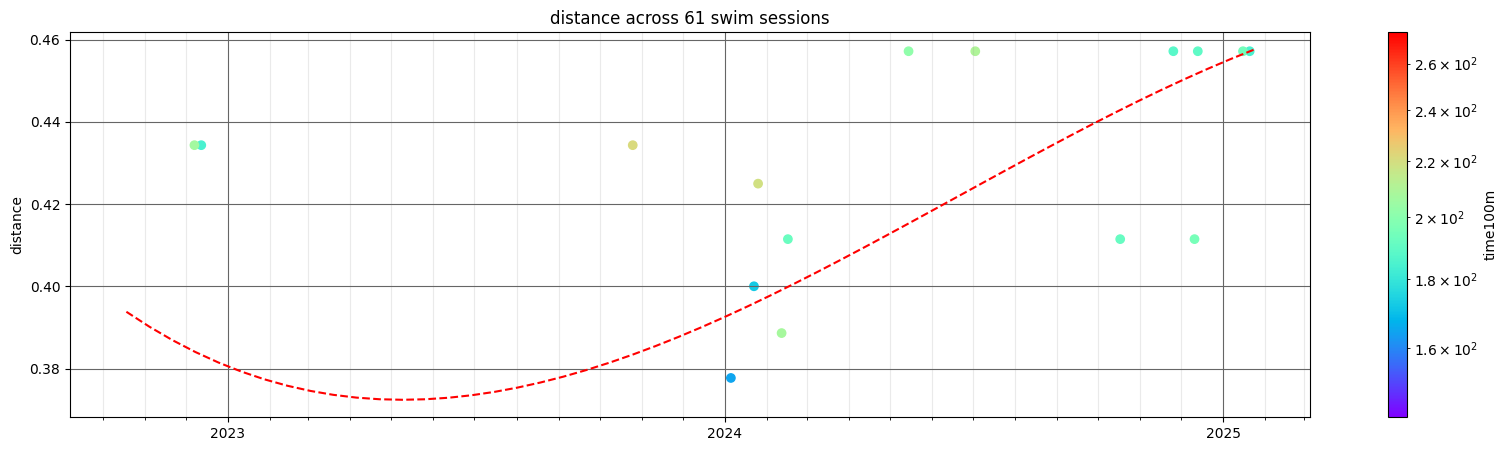

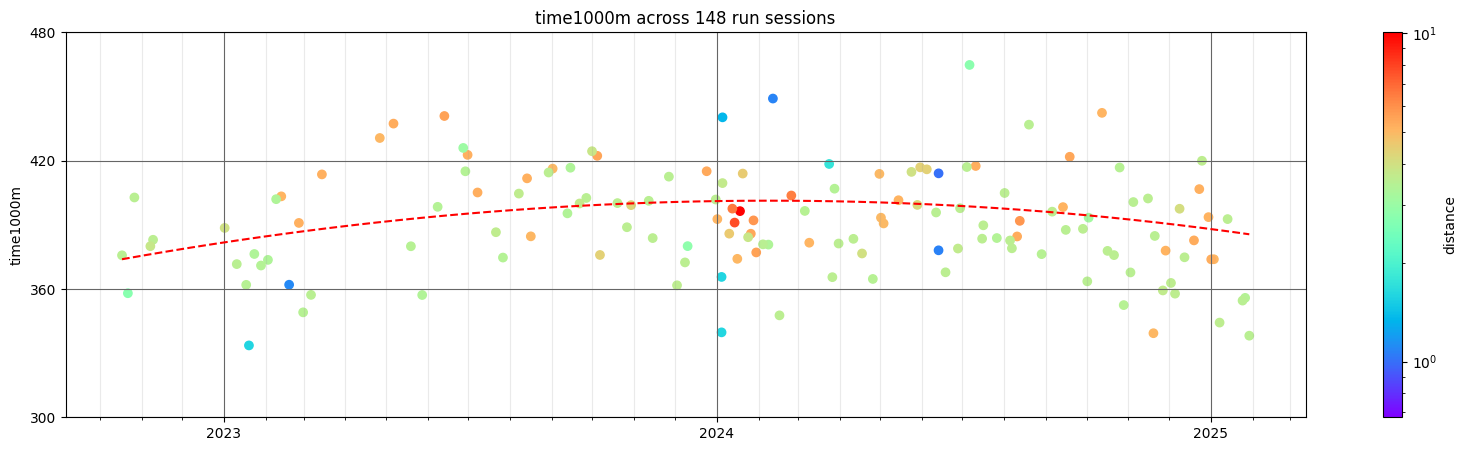

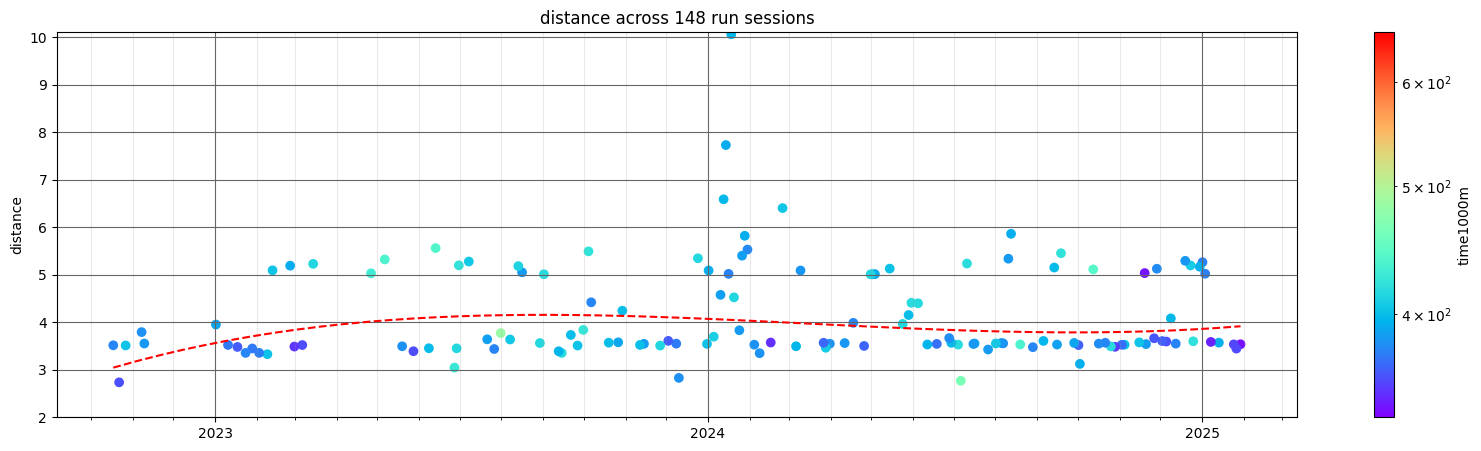

In [111]:
__plot_activity("swim", "time100m", "distance")
__plot_activity("swim", "distance", "time100m")
__plot_activity("run", "time1000m", "distance", yticksdata=[300, 360, 420, 480], ylimdata=[300, 480])
__plot_activity("run", "distance", "time1000m", ylimdata=[2, 10.1])


In [ ]:
# First 1km time

start_dates = []
moving_times = []
distances = []
time100m = []
for activity in activities:
    if ((activity.name is not None) and ("swim" in activity.name.lower())):
#         s = activity.distance
#         t = (datetime.combine(date.min, activity.moving_time) - datetime.min).total_seconds()
        
        laps = ActivityLaps.get_activity(garmin_act_db, activity.activity_id)
        s = 0
        t = 0
        for lap in laps:
            if (s < 1.0) and (lap.distance > 0.02):
                s += lap.distance
                t += (datetime.combine(date.min, lap.moving_time) - datetime.min).total_seconds()
        
        if (t/s/10 < 150) and (s > 0.8):
            time100m += [t/s/10]
            start_dates += [activity.start_time]
            moving_times += [t]
            distances += [s]


fig = plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(start_dates, time100m, c=distances, vmin=0.8, cmap="rainbow")

x_num = dates.date2num(start_dates)
trend = np.polyfit(x_num, time100m, 1)
fit = np.poly1d(trend)
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "r--")

ax = plt.gca()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
# yearsFmt = plt.matplotlib.dates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
# ax.xaxis.set_major_formatter(yearsFmt)

plt.title(f"Swim Time - laps until exceeding 1km\nRecorded Swims: {len(rows)}")
plt.colorbar(label="Total Distance / km")
plt.ylabel("Time per 100m (s)")
plt.ylim(min(time100m), 140)
plt.show()

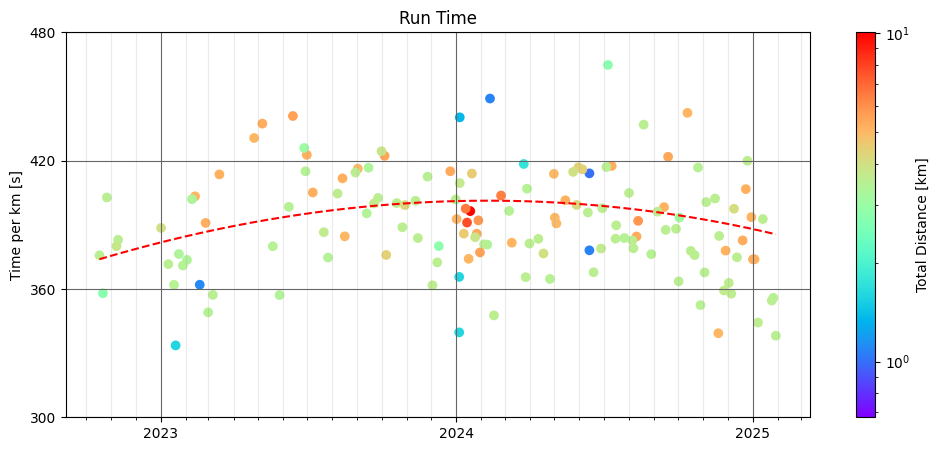

In [94]:
# Running

start_dates = []
moving_times = []
distances = []
time1000m = []
for activity in activities:
    if ((activity.name is not None) and ("run" in activity.name.lower())):
        s = activity.distance
        t = (datetime.combine(date.min, activity.moving_time) - datetime.min).total_seconds()
        
        #if (210 < t/s < 480) and (s > 0.5):
        time1000m += [t/s]
        start_dates += [activity.start_time]
        moving_times += [t]
        distances += [s]


fig = plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(start_dates, time1000m, c=distances, norm=matplotlib.colors.LogNorm(), cmap="rainbow")

x_num = dates.date2num(start_dates)
trend = np.polyfit(x_num, time1000m, 7)
fit = np.poly1d(trend)
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "r--")

ax = plt.gca()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
# yearsFmt = plt.matplotlib.dates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
# ax.xaxis.set_major_formatter(yearsFmt)

plt.title("Run Time")
plt.colorbar(label="Total Distance [km]")
plt.ylabel("Time per km [s]")
plt.ylim(300, 480)
plt.yticks([300, 360, 420, 480])
plt.show()

[datetime.datetime(2025, 2, 1, 13, 27, 33), datetime.datetime(2025, 1, 31, 12, 7, 21), datetime.datetime(2025, 1, 28, 21, 31, 3), datetime.datetime(2025, 1, 24, 8, 20, 4), datetime.datetime(2025, 1, 18, 7, 56, 48), datetime.datetime(2025, 1, 18, 7, 24, 23), datetime.datetime(2025, 1, 17, 13, 2, 48), datetime.datetime(2025, 1, 14, 21, 4, 43), datetime.datetime(2025, 1, 11, 8, 2, 33), datetime.datetime(2025, 1, 5, 7, 44, 38), datetime.datetime(2025, 1, 2, 15, 55, 38), datetime.datetime(2024, 12, 31, 20, 17, 53), datetime.datetime(2024, 12, 27, 12, 6, 51), datetime.datetime(2024, 12, 21, 8, 5, 10), datetime.datetime(2024, 12, 15, 14, 19, 58), datetime.datetime(2024, 12, 14, 13, 37, 14), datetime.datetime(2024, 12, 10, 21, 55, 58), datetime.datetime(2024, 12, 5, 21, 57, 57), datetime.datetime(2024, 11, 27, 9, 13), datetime.datetime(2024, 11, 14, 8, 6, 23), datetime.datetime(2024, 11, 11, 21, 32, 45), datetime.datetime(2024, 11, 9, 15, 42, 35), datetime.datetime(2024, 11, 9, 14, 56, 28), datetime.datetime(2024, 11, 7, 22, 25, 54), datetime.datetime(2024, 11, 7, 8, 17, 25), datetime.datetime(2024, 11, 5, 22, 12), datetime.datetime(2024, 11, 5, 14, 15, 1), datetime.datetime(2024, 11, 3, 20, 13, 27), datetime.datetime(2024, 11, 2, 15, 4, 21), datetime.datetime(2024, 11, 2, 13, 1, 7), datetime.datetime(2024, 10, 26, 16, 18, 42), datetime.datetime(2024, 10, 26, 15, 15, 46), datetime.datetime(2024, 10, 22, 12, 34, 53), datetime.datetime(2024, 10, 17, 21, 49, 25), datetime.datetime(2024, 10, 12, 11, 43, 52), datetime.datetime(2024, 10, 7, 11, 51, 42), datetime.datetime(2024, 10, 3, 18, 5, 57), datetime.datetime(2024, 9, 24, 13, 45, 38), datetime.datetime(2024, 9, 16, 17, 41, 21), datetime.datetime(2024, 9, 9, 10, 15), datetime.datetime(2024, 9, 8, 16, 27, 54), datetime.datetime(2024, 9, 7, 16, 32, 43), datetime.datetime(2024, 9, 1, 15, 50, 14), datetime.datetime(2024, 8, 22, 21, 23, 52), datetime.datetime(2024, 7, 25, 21, 58, 7), datetime.datetime(2024, 7, 21, 15, 22, 59), datetime.datetime(2024, 7, 19, 22, 31, 55), datetime.datetime(2024, 7, 9, 12, 39, 6), datetime.datetime(2024, 6, 12, 21, 38, 17), datetime.datetime(2024, 6, 2, 23, 15), datetime.datetime(2024, 5, 29, 22, 10, 52), datetime.datetime(2024, 5, 29, 21, 40, 57), datetime.datetime(2024, 5, 28, 22, 48, 40), datetime.datetime(2024, 5, 25, 15, 56, 11), datetime.datetime(2024, 5, 12, 11, 0, 31), datetime.datetime(2024, 5, 9, 21, 27, 16), datetime.datetime(2024, 5, 7, 22, 48, 55), datetime.datetime(2024, 4, 23, 21, 54, 17), datetime.datetime(2024, 4, 21, 8, 45, 21), datetime.datetime(2024, 4, 18, 21, 38, 36), datetime.datetime(2024, 4, 17, 23, 18, 26), datetime.datetime(2024, 3, 25, 21, 20), datetime.datetime(2024, 3, 23, 10, 47, 36), datetime.datetime(2024, 3, 21, 22, 59, 33), datetime.datetime(2024, 3, 20, 21, 54, 48), datetime.datetime(2024, 2, 28, 9, 49, 32), datetime.datetime(2024, 2, 23, 9, 7, 8), datetime.datetime(2024, 2, 21, 9, 13, 48), datetime.datetime(2024, 2, 20, 15, 55, 24), datetime.datetime(2024, 2, 19, 8, 12, 50), datetime.datetime(2024, 2, 17, 11, 24, 36), datetime.datetime(2024, 2, 11, 15, 45, 53), datetime.datetime(2024, 2, 4, 9, 18, 19), datetime.datetime(2024, 1, 29, 14, 29, 43), datetime.datetime(2024, 1, 27, 14, 33, 41), datetime.datetime(2024, 1, 25, 14, 11, 12), datetime.datetime(2024, 1, 20, 14, 11, 38), datetime.datetime(2024, 1, 17, 13, 51, 8), datetime.datetime(2024, 1, 8, 15, 11, 9), datetime.datetime(2023, 12, 29, 14, 32, 20), datetime.datetime(2023, 12, 14, 16, 8, 13), datetime.datetime(2023, 12, 11, 21, 52, 4), datetime.datetime(2023, 12, 1, 8, 56, 42), datetime.datetime(2023, 11, 29, 8, 29, 32), datetime.datetime(2023, 11, 27, 8, 45, 6), datetime.datetime(2023, 11, 21, 8, 37, 30), datetime.datetime(2023, 11, 7, 20, 59, 18), datetime.datetime(2023, 10, 30, 17, 37, 8), datetime.datetime(2023, 10, 30, 9, 36, 48), datetime.datetime(2023, 10, 26, 21, 30, 29), datetime.datetime(2023, 10, 25, 22, 14, 58), datetime.datetime(2023, 10, 15, 14, 14, 57), datetime.datetime(2023, 10, 11, 12, 5, 41), datetime.datetime(2023, 10, 6, 15, 15, 44), datetime.datetime(2023, 10, 5, 22, 8, 56), datetime.datetime(2023, 10, 3, 23, 37, 11), datetime.datetime(2023, 9, 27, 16, 6), datetime.datetime(2023, 9, 24, 14, 49, 53), datetime.datetime(2023, 9, 19, 6, 48, 50), datetime.datetime(2023, 9, 18, 20, 42, 49), datetime.datetime(2023, 9, 18, 6, 41, 5), datetime.datetime(2023, 9, 12, 21, 56, 46), datetime.datetime(2023, 9, 3, 9, 38, 55), datetime.datetime(2023, 9, 1, 21, 17, 43), datetime.datetime(2023, 7, 5, 22, 5, 36), datetime.datetime(2023, 6, 26, 8, 30, 39), datetime.datetime(2023, 6, 5, 21, 38, 34), datetime.datetime(2023, 4, 17, 11, 54, 38), datetime.datetime(2023, 4, 7, 12, 50, 21), datetime.datetime(2023, 3, 28, 15, 20, 25), datetime.datetime(2023, 3, 24, 11, 32, 55), datetime.datetime(2023, 3, 12, 14, 24, 23), datetime.datetime(2023, 3, 9, 12, 54, 51), datetime.datetime(2023, 3, 9, 12, 33, 25), datetime.datetime(2023, 2, 23, 13, 17, 22), datetime.datetime(2023, 2, 6, 21, 41, 50), datetime.datetime(2023, 2, 3, 12, 38, 16), datetime.datetime(2023, 1, 29, 10, 40, 28), datetime.datetime(2023, 1, 22, 13, 4, 38), datetime.datetime(2023, 1, 6, 13, 21, 26), datetime.datetime(2022, 12, 18, 10, 14, 56), datetime.datetime(2022, 10, 16, 13, 6, 11)]

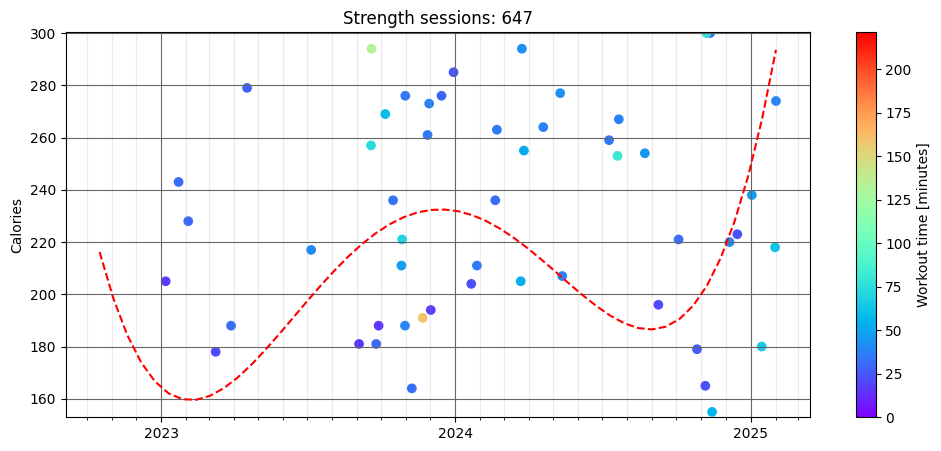

In [18]:
import numpy as np

start_dates = []
moving_times = []
calories = []
for activity in activities:
    if ((activity.name is not None) and ("strength" in activity.name.lower())):
        s = activity.distance
        t = (datetime.combine(date.min, activity.moving_time) - datetime.min).total_seconds()
        start_dates += [activity.start_time]
        moving_times += [t/60]
        calories += [activity.calories]

fig = plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(start_dates, calories, c=moving_times, vmin=0, cmap="rainbow")

x_num = dates.date2num(start_dates)

display(Markdown(str(start_dates)))

trend = np.polyfit(x_num, calories, 4)
fit = np.poly1d(trend)
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "r--")

ax = plt.gca()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
# yearsFmt = plt.matplotlib.dates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
# ax.xaxis.set_major_formatter(yearsFmt)

plt.title(f"Strength sessions: {len(rows)}")
plt.colorbar(label="Workout time [minutes]")
plt.ylabel("Calories")
#plt.ylim(0, max(moving_times))
plt.show()